In [1]:
from astropy.io import fits
import numpy as np
from astropy.io import fits
import os
import matplotlib.pyplot as plt
from astropy.stats import SigmaClip
from photutils.background import Background2D,SExtractorBackground
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from scipy import ndimage
from scipy.ndimage import gaussian_filter
import little_things_functions as ltf
import cv2
#plt.gray()
galaxy_name = 'DDO43'
box_size = 200
window_size = (40, 40)


# import files----------------------------------------------------------------------------------------------------------------------------------------------------
light_file_u = fits.open(r"C:/Users\AYSAN\Desktop/project/Galaxy\Data\DDO 43\d43u.fits")
light_u = light_file_u[0].data

light_file_b = fits.open(r"C:/Users\AYSAN\Desktop/project/Galaxy\Data\DDO 43\d43B.fits")
light_b = light_file_b[0].data

light_file_v = fits.open(r"C:/Users\AYSAN\Desktop/project/Galaxy\Data\DDO 43\d43V.fits")
light_v = light_file_v[0].data

box_u = (100 , 100)
box_b = (130 , 130)
box_v = (170 , 170)

lights = [light_u,light_b,light_v]
boxes = [box_u,box_b,box_v]
filters = ["U" , "B" , "V"]
print(np.shape(light_u), np.shape(light_b), np.shape(light_v))

(985, 985) (916, 883) (916, 883)


(916, 883) (916, 883) (916, 883)


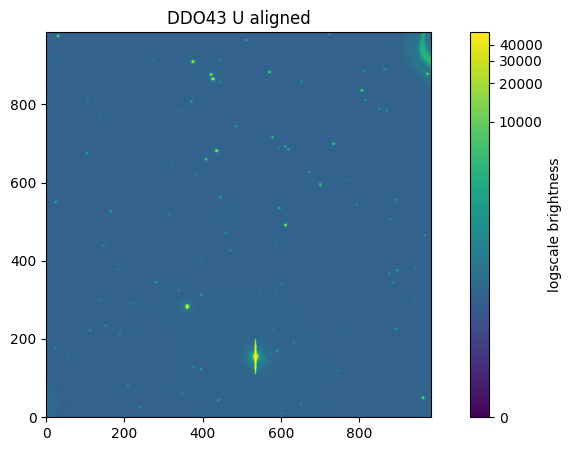

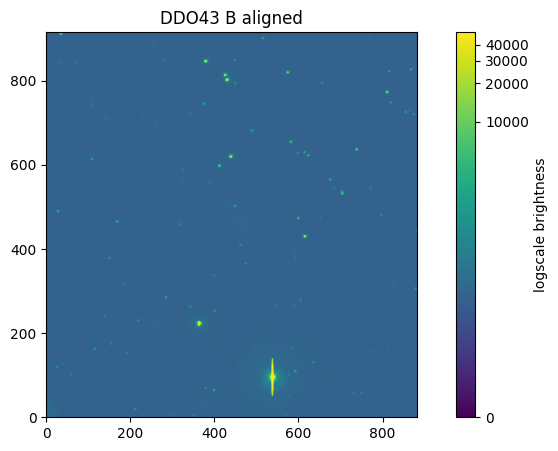

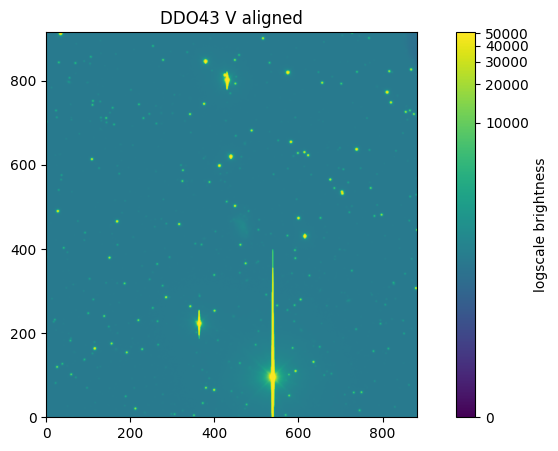

In [2]:
import astroalign as aa
target_fixed = lights[2].byteswap().newbyteorder('N')
source_fixed_1 = lights[0].byteswap().newbyteorder('N')
source_fixed_2 = lights[1].byteswap().newbyteorder('N')

registered_image_1, footprint_1 = aa.register(source_fixed_1, target_fixed)
registered_image_2,  footprint_2 = aa.register(source_fixed_2, target_fixed)
list_of_aligned_images = [lights[0], registered_image_1, registered_image_2]

print(np.shape(list_of_aligned_images[1]),np.shape(list_of_aligned_images[2]), np.shape(list_of_aligned_images[2]))
aligned = list_of_aligned_images

for i in range(0,3):
    ltf.log_scale_plot(aligned[i],"%s %s aligned"%(galaxy_name,filters[i]),"logscale brightness")

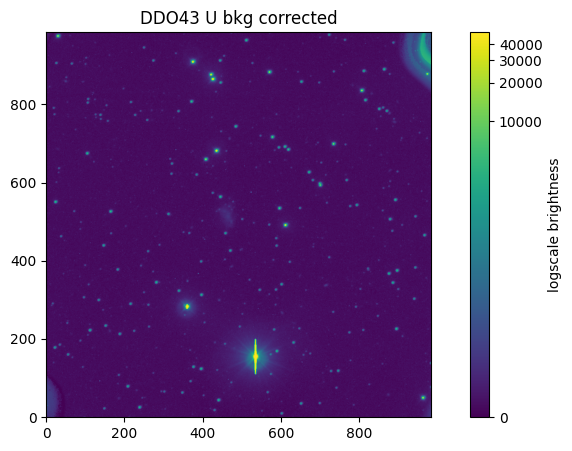

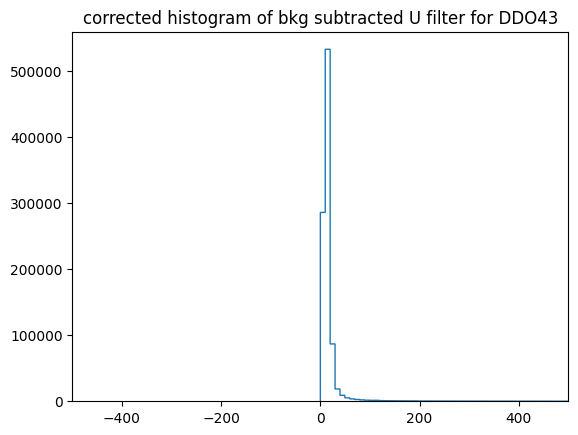

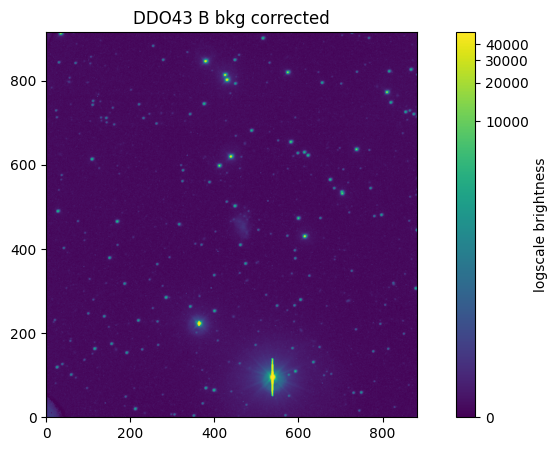

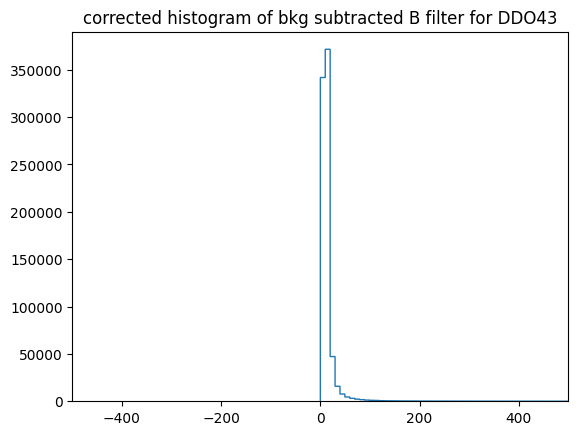

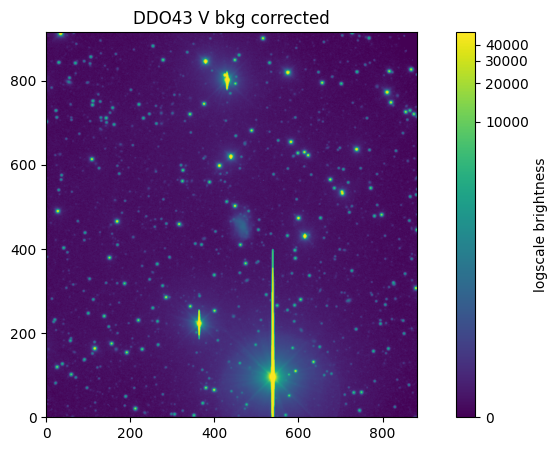

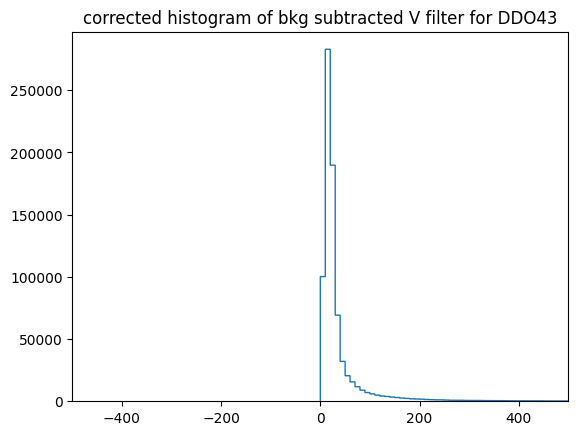

In [3]:
corrected = ltf.background_subtraction(aligned,3,boxes,(3,3))
for i in range(0,3):
    ltf.log_scale_plot(corrected[i],"%s %s bkg corrected"%(galaxy_name,filters[i]),"logscale brightness")
    output_filename = '%s_%s_background_subtracted.fits'%(galaxy_name,filters[i])
    # Create a PrimaryHDU (header/data unit) from your array
    primary_hdu = fits.PrimaryHDU(corrected[i])
    # Create an HDUList and append the PrimaryHDU
    hdul = fits.HDUList([primary_hdu])
    # Write the HDUList to the FITS file
    #hdul.writeto(output_filename, overwrite=True)
    counts, bins = np.histogram(corrected[i], 5000)
    plt.stairs(counts, bins)
    plt.xlim([-500, 500])
    plt.title("corrected histogram of bkg subtracted %s filter for %s" %(filters[i] , galaxy_name))
    plt.show()

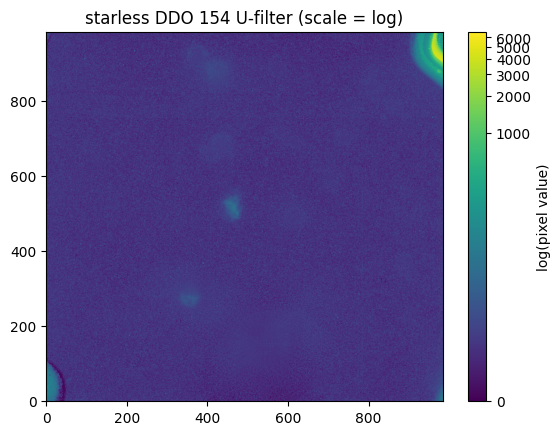

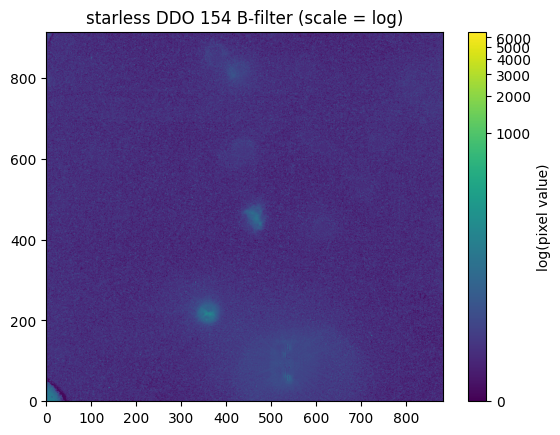

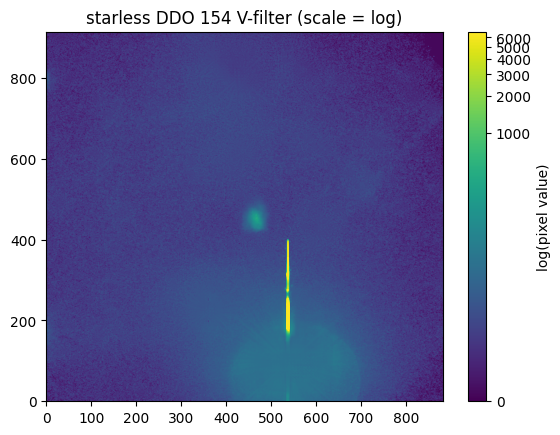

In [4]:
# import starless files----------------------------------------------------------------------------------------------------------------------------------------------------
starless_file_u = fits.open(r"C:\Users\AYSAN\Desktop\project\Galaxy\Code\d43\starless\starless_DDO43_U_background_subtracted.fit")
starless_u = starless_file_u[0].data
starless_u[starless_u <= 0] = 1
starless_file_b = fits.open(r"C:\Users\AYSAN\Desktop\project\Galaxy\Code\d43\starless\starless_DDO43_b_background_subtracted.fit")
starless_b = starless_file_b[0].data
starless_b[starless_b <= 0] = 1
starless_file_v = fits.open(r"C:\Users\AYSAN\Desktop\project\Galaxy\Code\d43\starless\starless_DDO43_v_background_subtracted.fit")
starless_v = starless_file_v[0].data
starless_v[starless_v <= 0] = 1

starless = [starless_u , starless_b , starless_v]

norm = ImageNormalize(vmin=0., stretch=LogStretch())
for i in range(0 , len(starless)):
    
    plt.imshow(starless[i] , origin = "lower" , aspect='auto', norm = norm)
    plt.title('starless DDO 154 %s-filter (scale = log)'%(filters[i]))
    cbar = plt.colorbar()
    cbar.set_label('log(pixel value)')
    plt.show()

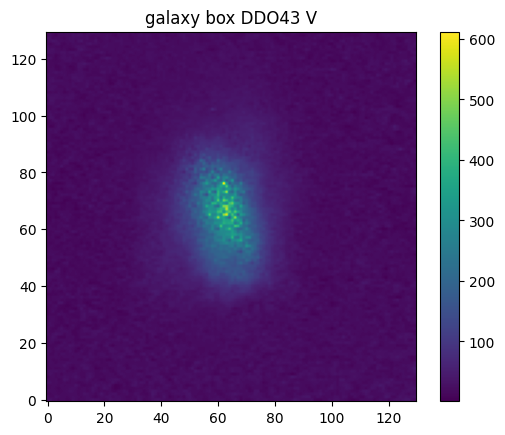

In [5]:
box_size_x = 65
box_size_y = 65


box_center = [470,450]

galaxy_boxes = []
for i in range(0 , len(starless)):
        box = starless[i][box_center[1] - box_size_y : box_center[1] + box_size_y, box_center[0] - box_size_x : box_center[0] + box_size_x]
        galaxy_boxes.append(box)


plt.imshow(galaxy_boxes[2], origin = "lower")
plt.title("galaxy box %s %s"%(galaxy_name,filters[2]))
plt.colorbar()
plt.show()
    

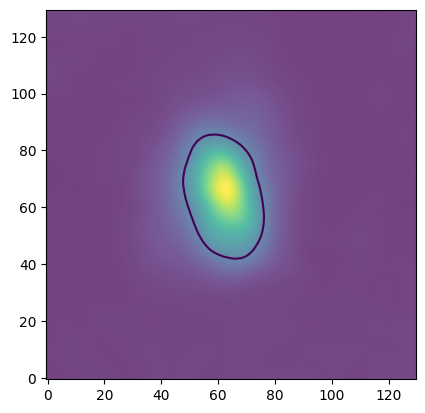

In [6]:
v_value_box = galaxy_boxes[2]
contour_points = ltf.contour_lines_coordinates(v_value_box, 3, [120])
x_points , y_points = contour_points

(64.5078788774488, 63.32925595677948)
13.391989372216019
[62.12851401 63.84330995 13.39198937 22.59845036  0.22653466]


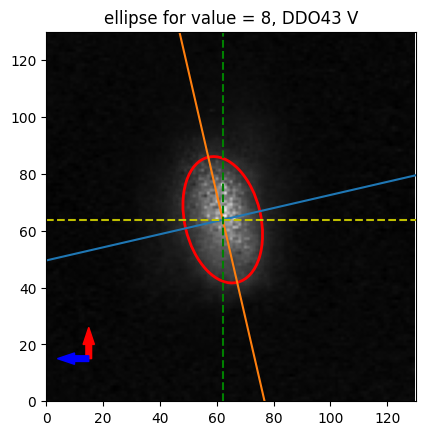

what we measure  12.979480079388317
paper = 48.5


In [7]:
image_center_of_mass = ndimage.center_of_mass(v_value_box)
print(image_center_of_mass)
#coordinates
x, y = image_center_of_mass[1], image_center_of_mass[0]
from scipy.ndimage import gaussian_filter
import cv2
from scipy.optimize import curve_fit
from matplotlib.patches import Ellipse
initial_guess = [x, y, (max(x_points) - min(x_points)) / 2 , (max(y_points) - min(y_points)) / 2 , 0]
popt, pcov = curve_fit(ltf.ellipse, (x_points, y_points), np.zeros_like(x_points), p0=initial_guess)
stdv=np.sqrt(np.diag(pcov))
stdvx=stdv[0]
stdvy=stdv[1]
stdva=stdv[2]
stdvb=stdv[3]
stdvpa=stdv[4]

xc, yc, a, b, theta = popt

curve = ltf.ellipse(x_points,popt[0],popt[1],popt[2],popt[3],popt[4])

xc, yc, a, b, theta = popt
print(a)
print(popt)
# Create a figure and axis
plt.figure()
ax = plt.gca()

# Display the other image
ax.imshow(v_value_box, cmap='gray' , origin = "lower")

# Create the ellipse
ellipse = Ellipse(xy=(xc, yc), width=2*a, height=2*b, angle=np.degrees(theta), edgecolor='r', facecolor='none', linewidth=2)

# Add the ellipse to the axis
ax.add_patch(ellipse)
m = np.tan(theta)
x_ax = np.arange(0,400)
Y_ax = m*(x_ax-xc) + yc
ax.plot(x_ax,Y_ax)

Y_prime_ax = (-1/m)*(x_ax-xc) + yc
ax.plot(x_ax,Y_prime_ax)

plt.axhline(y=yc, color='y', linestyle='--', label = "East-West line")
plt.axvline(x=xc,  color='g', linestyle='--', label="theta = 0")

# Set axis limits (adjust as needed)
ax.set_xlim(0,v_value_box.shape[1])
ax.set_ylim(0,v_value_box.shape[0])  # Reverse y-axis for imshow
plt.title("ellipse for vlaue = 30, DDO168 V")
# Show the plot
# Example: Add arrows for north and east
plt.arrow(x=15, y=15, dx=0, dy=5, color='red', width=2, head_width=4)
plt.arrow(x=15, y=15, dx=-5, dy=0, color='blue', width=2, head_width=4)

# Set axis limits (adjust as needed)
ax.set_xlim(0,v_value_box.shape[1])
ax.set_ylim(0,v_value_box.shape[0])  # Reverse y-axis for imshow
plt.title("ellipse for value = 8, DDO43 V")
# Show the plot
plt.show()

import math
angle_in_degrees = math.degrees(theta)

print("what we measure " , angle_in_degrees)


print("paper = 48.5")


C:\Users\AYSAN\AppData\Local\Temp\ipykernel_13128\1695093212.py:3: DeprecationWarning: `photutils.aperture_photometry` is a deprecated alias for `photutils.aperture.aperture_photometry` and will be removed in the future. Instead, please use `from photutils.aperture import aperture_photometry` to silence this warning.
  from photutils import aperture_photometry


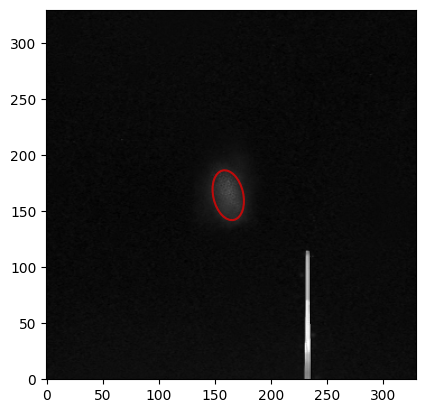

In [8]:
from astropy.coordinates import Angle
from photutils.aperture import EllipticalAperture
from photutils import aperture_photometry
plus = 100
bigger_v_box = starless[2][box_center[1] - (box_size_y+plus) : box_center[1] + (box_size_y+plus), box_center[0] - (box_size_x+plus) : box_center[0] + (box_size_x+plus)]

elliptical_center_box = (xc,yc)
new_xc = xc + int(plus)
new_yc = yc + int(plus)
elliptical_center = (new_xc,new_yc)
ellipse_aper = EllipticalAperture(elliptical_center, a, b, theta)
norm = ImageNormalize(vmin=0., stretch=LogStretch())
plt.imshow(bigger_v_box, cmap='gray', origin = "lower" , norm = norm) 
ellipse_aper.plot(color='red', lw=1.5, alpha=0.7) 
plt.show()
phot_table = aperture_photometry(bigger_v_box, ellipse_aper)
aperture_sum_A = phot_table['aperture_sum'][0] 

C:\Users\AYSAN\AppData\Local\Temp\ipykernel_13128\1352939632.py:3: DeprecationWarning: `photutils.EllipticalAperture` is a deprecated alias for `photutils.aperture.EllipticalAperture` and will be removed in the future. Instead, please use `from photutils.aperture import EllipticalAperture` to silence this warning.
  from photutils import EllipticalAperture, aperture_photometry
C:\Users\AYSAN\AppData\Local\Temp\ipykernel_13128\1352939632.py:3: DeprecationWarning: `photutils.aperture_photometry` is a deprecated alias for `photutils.aperture.aperture_photometry` and will be removed in the future. Instead, please use `from photutils.aperture import aperture_photometry` to silence this warning.
  from photutils import EllipticalAperture, aperture_photometry


13.391989372216019
Aperture sums: [1.121548577331556e-09, 138.73115582764507, 566.8777907563671, 1321.0412711467138, 2356.320982615542, 3628.786889447749, 5152.7116775893965, 6963.333971643768, 9081.450285809162, 11581.98486264556, 14339.150094923194, 17167.37424285008, 20073.203507887265, 23139.091721474288, 26510.20923953182, 30208.365276967008, 34099.96617262444, 38132.50808524978, 42255.66236129044, 46445.84069760523, 50779.75478671692, 55276.3365094349, 59944.44614916676, 64683.74166023341, 69456.2122361928, 74318.35089682657, 79240.96028661962, 84244.51602816515, 89319.47659798266, 94361.13878821116, 99365.89941900567, 104454.97172996933, 109648.71570663457, 114909.22370412957, 120177.99466474968, 125390.79137285442, 130566.56229885522, 135748.58265743626, 140930.5005382676, 146128.29012274038, 151301.0647755315, 156389.45668371307, 161434.732837398, 166400.50743369423, 171333.15861386462, 176214.46464852418, 181070.16864385837, 185894.57896256482, 190691.7388675869, 195396.36362

Text(0.5, 1.0, ' curve of growth for DDO154')

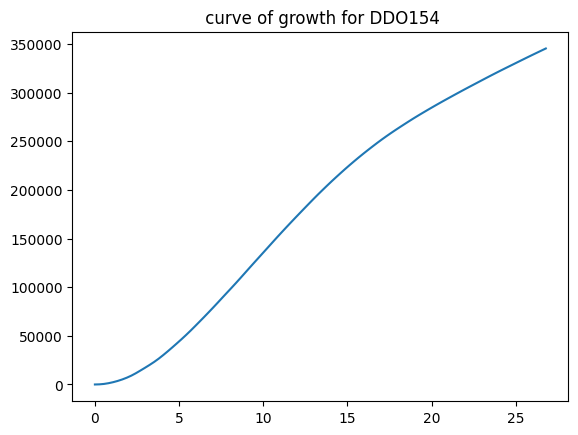

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from photutils import EllipticalAperture, aperture_photometry

# Assuming you have defined 'a', 'b', 'theta', 'elliptical_center', and 'v_value_box'
ab_ratio = a / b
ba_ratio = b / a
print(a)
a_list = np.linspace(0, 2*a, 100)
b_list = ba_ratio * a_list

sum_values = []

for i in range(len(a_list)):
    # Ensure positive scalar values for major and minor axes
    a_i = max(a_list[i], 1e-6)  # Avoid zero or negative values
    b_i = max(b_list[i], 1e-6)
    ellipse_aper = EllipticalAperture(elliptical_center, a_i, b_i, theta)
    '''
    plt.imshow(bigger_v_box, cmap='gray')  # Replace 'image_data' with your data
    ellipse_aper.plot(color='red', lw=1.5, alpha=0.7)  # Overlay the aperture
    plt.show()
    '''
    # Compute the aperture sum
    phot_table = aperture_photometry(bigger_v_box, ellipse_aper)
    aperture_sum_A = phot_table['aperture_sum'][0]
    sum_values.append(aperture_sum_A)

print("Aperture sums:", sum_values)

plt.plot(a_list , sum_values)
plt.title(" curve of growth for DDO154")

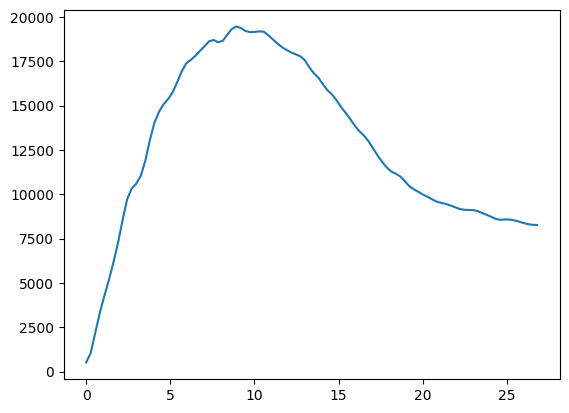

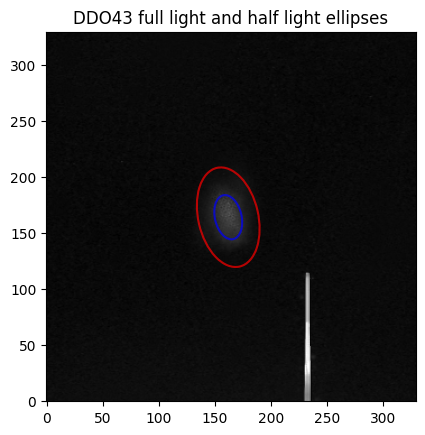

galaxy parameter a =  26.783978744432037 and galaxy parameter b =  45.196900720761
galaxy count 345405.7993473133
galaxy half light a =  11.903990553080906 and galaxy half light b =  20.087511431449332
half light count 171333.15861386462
0.4960344005156245


In [10]:
gradient_sum = np.gradient(sum_values, a_list)
plt.plot(a_list, gradient_sum)
plt.show()
import numpy as np
from scipy.signal import find_peaks
peaks, _ = find_peaks(gradient_sum)
peak_index = peaks[0]
min_after_peak = np.min(gradient_sum[peak_index + 1:])
min_index_after_peak = np.where(gradient_sum == min_after_peak)[0][0]

galaxy_parameter_a = a_list[min_index_after_peak]
galaxy_parameter_b = galaxy_parameter_a*ba_ratio
whole_galaxy = sum_values[min_index_after_peak]

half_light_estimated = whole_galaxy/2
half_light_index = min(range(len(sum_values)), key=lambda i: abs(sum_values[i] - half_light_estimated))

a_half_light = a_list[half_light_index]
b_half_light = a_half_light * ba_ratio

ellipse_aper_full_light = EllipticalAperture(elliptical_center, galaxy_parameter_a, galaxy_parameter_b, theta)
ellipse_aper_half_light = EllipticalAperture(elliptical_center, a_half_light, b_half_light, theta)
norm = ImageNormalize(vmin=0., stretch=LogStretch())
plt.imshow(bigger_v_box, cmap='gray', origin = "lower" , norm = norm) 
ellipse_aper_full_light.plot(color='red', lw=1.5, alpha=0.7) 
ellipse_aper_half_light.plot(color='blue', lw=1.5, alpha=0.7)
plt.title("%s full light and half light ellipses" %(galaxy_name))
plt.show()

print("galaxy parameter a = ", galaxy_parameter_a, "and galaxy parameter b = " , galaxy_parameter_b)
print("galaxy count", sum_values[min_index_after_peak])
print("galaxy half light a = ", a_half_light, "and galaxy half light b = " , b_half_light)
print("half light count", sum_values[half_light_index])
ratio = sum_values[half_light_index]/whole_galaxy
print(ratio)

In [24]:
pixel_scale = 1.134
D = 5.5

a_half_light_arcsec = b_half_light * pixel_scale


RV_half = (D * a_half_light_arcsec)/206265

print("RV1/2 for DDO69 is: ", RV_half*(10**3), "kpc")
print("paper value is 0.67 kpc")

a_kpc = 0.67
a_half_paper = (a_kpc *206265)/(D*pixel_scale*10**3)
print("a_half_paper_pixels", a_half_paper)

RV1/2 for DDO69 is:  0.6074021709836834 kpc
paper value is 0.67 kpc
a_half_paper_pixels 22.157696007696014


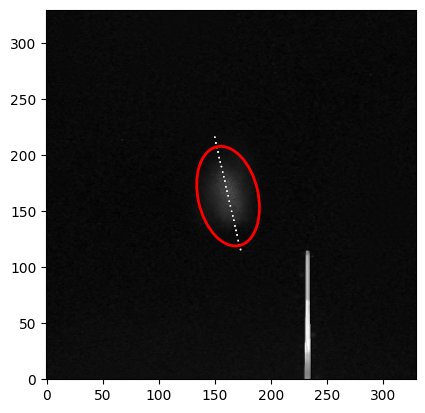

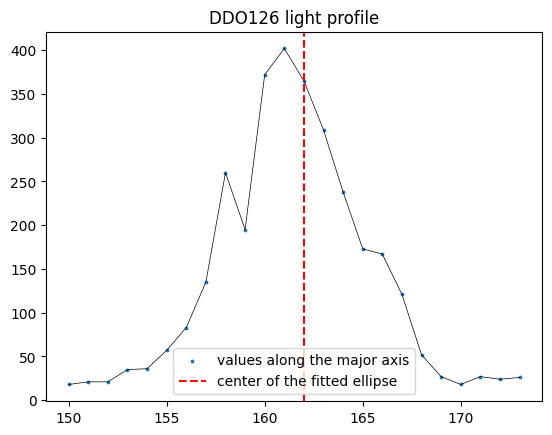

In [12]:
new_xc = int(new_xc)
new_yc = int(new_yc)
x_ax_left = np.arange(150, new_xc)
x_ax_right = np.arange(new_xc, (new_xc-150)+new_xc)
import copy
duplicated_array = copy.copy(bigger_v_box)
def get_line_values(array, yc, x_ax):
    values = []
    for x in x_ax:
        y = int(-1/m * (x) + yc - (-1/m)*new_xc)
        values.append(array[y, x])
        duplicated_array = copy.copy(array)
        array[y, x] = 65535
            
    return values

norm = ImageNormalize(vmin=0., stretch=LogStretch())
plt.figure()
ax = plt.gca()
values_along_line_left = get_line_values(bigger_v_box, new_yc, x_ax_left)
values_along_line_right = get_line_values(bigger_v_box, new_yc, x_ax_right)

# Display the other image
ax.imshow(bigger_v_box, cmap='gray' , origin = "lower", norm = norm)
angle_in_degrees = np.degrees(theta)
# Create the ellipse
ellipse = Ellipse(xy=(new_xc, new_yc), width=2*galaxy_parameter_a, height=2*galaxy_parameter_b, angle=np.degrees(theta), edgecolor='r', facecolor='none', linewidth=2)
# Add the ellipse to the axis
ax.add_patch(ellipse)
plt.show()
values_along_line = values_along_line_left + values_along_line_right
   
x_ax = np.arange(np.min(x_ax_left), np.max(x_ax_right)+1)
plt.scatter(x_ax , values_along_line, s = 3, label='values along the major axis')
plt.plot(x_ax , values_along_line, color = "black" , linewidth = 0.5)
plt.axvline(x=new_xc, color='r', linestyle='--', label='center of the fitted ellipse')
plt.legend()
plt.title("DDO126 light profile")
plt.show()

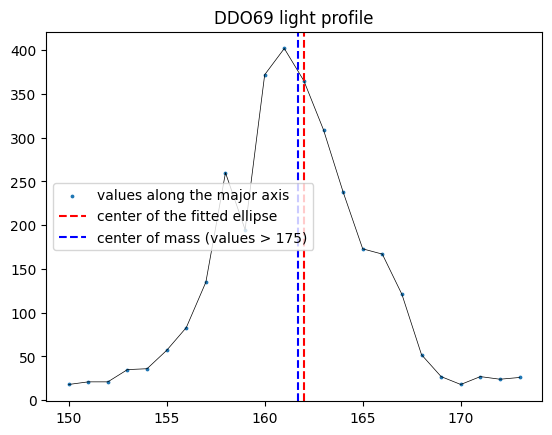

Center of mass of data points with values larger than 175: 161


In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming values_along_line_left and values_along_line_right are already defined
values_along_line = values_along_line_left + values_along_line_right
values_along_line = np.array(values_along_line)  # Convert to NumPy array
x_ax = np.arange(np.min(x_ax_left), np.max(x_ax_right) + 1)

# Get the data points with values larger than 100
mask = values_along_line > 150
values_above_100 = values_along_line[mask]
x_above_100 = x_ax[mask]

# Calculate the center of mass
center_of_mass = np.sum(x_above_100 * values_above_100) / np.sum(values_above_100)

# Plotting the data
plt.scatter(x_ax, values_along_line, s=3, label='values along the major axis')
plt.plot(x_ax, values_along_line, color="black", linewidth=0.5)
plt.axvline(x=new_xc, color='r', linestyle='--', label='center of the fitted ellipse')
plt.axvline(x=center_of_mass, color='b', linestyle='--', label='center of mass (values > 175)')
plt.title("DDO69 light profile")
plt.legend()
plt.show()
center_of_mass = int(center_of_mass)
# Print the center of mass
print("Center of mass of data points with values larger than 175:", center_of_mass)


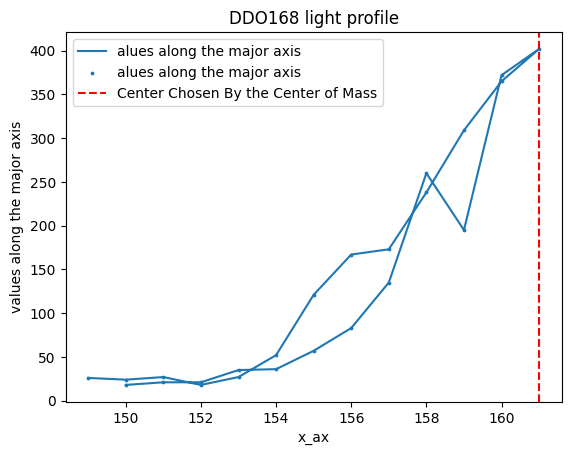

In [14]:
# Initialize the new lists
x_ax_left = []
x_ax_right = []
values_along_line_left = []
values_along_line_right = []

# Split the lists based on center_of_mass
for x, y in zip(x_ax, values_along_line):
    if x < center_of_mass:
        x_ax_left.append(x)
        values_along_line_left.append(y)
    else:
        x_ax_right.append(x)
        values_along_line_right.append(y)
x_ax_mirrored = x_ax_left + [2 * center_of_mass - x for x in x_ax_right]
values_along_line_mirrored = values_along_line_left + values_along_line_right

# Plotting
plt.plot(x_ax_mirrored, values_along_line_mirrored,label='alues along the major axis')
plt.scatter(x_ax_mirrored, values_along_line_mirrored,s=3,label='alues along the major axis')
plt.axvline(x=center_of_mass, color='red', linestyle='--', label='Center Chosen By the Center of Mass')
plt.xlabel('x_ax')
plt.ylabel('values along the major axis')
plt.title('DDO168 light profile')
plt.legend()
plt.show()

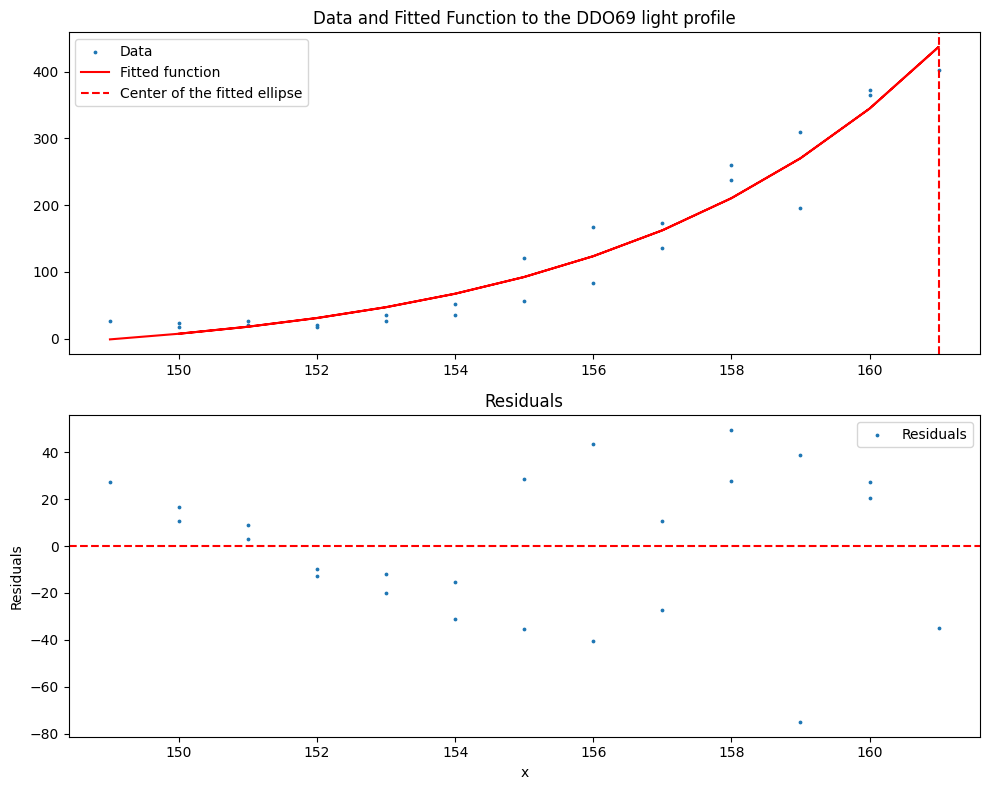

Exponential fit function is a * exp(b * (x - x0)) + c
a is 181.1980 +/- 1258278946.0626
b is 0.2174 +/- 0.0409
c is -35.9770 +/- 31.1838
x0 is 156.5880 +/- 31945509.1544
b is 0.2174 +/- 0.0409
1/b is 4.6003


In [15]:
def exponential_func(x, a, b, c, x0):
    return a * np.exp(b * (x - x0)) + c

# Provide initial guesses for the parameters
initial_guesses = [45, 0.1, 25, 0]
popt, pcov = curve_fit(exponential_func, x_ax_mirrored, values_along_line_mirrored, p0=initial_guesses)

# Plot the original data and the fitted function
plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
plt.scatter(x_ax_mirrored, values_along_line_mirrored, s=3, label='Data')
plt.plot(x_ax_mirrored, exponential_func(x_ax_mirrored, *popt), label='Fitted function', color='red')
plt.axvline(x=center_of_mass, color='r', linestyle='--', label='Center of the fitted ellipse')
plt.legend()
plt.title('Data and Fitted Function to the DDO69 light profile')

# Calculate residuals
residuals = values_along_line_mirrored - exponential_func(x_ax_mirrored, *popt)

# Plot the residuals
plt.subplot(2, 1, 2)
plt.scatter(x_ax_mirrored, residuals, s=3, label='Residuals')
plt.axhline(0, color='red', linestyle='--')
plt.legend()
plt.title('Residuals')
plt.xlabel('x')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()

# Calculate the standard deviation errors on the parameters
perr = np.sqrt(np.diag(pcov))
print("Exponential fit function is a * exp(b * (x - x0)) + c")
print(f"a is {popt[0]:.4f} +/- {perr[0]:.4f}")
print(f"b is {popt[1]:.4f} +/- {perr[1]:.4f}")
print(f"c is {popt[2]:.4f} +/- {perr[2]:.4f}")
print(f"x0 is {popt[3]:.4f} +/- {perr[3]:.4f}")

print(f"b is {popt[1]:.4f} +/- {perr[1]:.4f}")
print(f"1/b is {1/popt[1]:.4f}")


In [16]:
airmass_values=[1.16, 1.49, 1.11]
pixel_scale = 1.134
exposures = [1800, 1200, 600]
mU_values = [5.196, 0.4683865, -0.093,  0.]
mB_values = [3.562, 0.2586217, -0.0166, 0.]
mV_values = [3.017, 0.128904 ,  0.045,  0.]
m_values = [mU_values,mB_values,mV_values]

plt.imshow(ltf.mag_table_correction(starless,airmass_values,m_values,pixel_scale,exposures)[2] , origin="lower")
plt.title("ddo154 V magtable")
plt.colorbar()
plt.show()

plt.imshow(ltf.mag_table_correction(galaxy_boxes,airmass_values,m_values,pixel_scale,exposures)[2] , origin="lower")
plt.title("ddo154 V magtable")
plt.colorbar()
plt.show()

ValueError: operands could not be broadcast together with shapes (985,985) (916,883) 

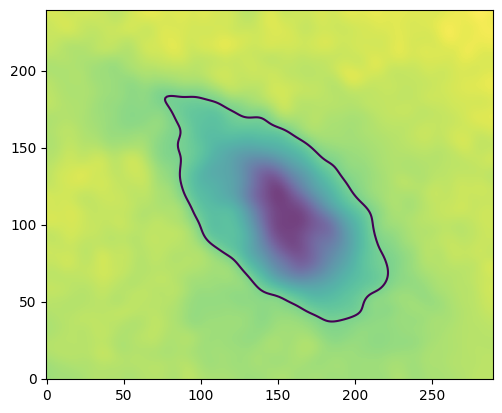

In [ ]:
v_box = ltf.mag_table_correction(galaxy_boxes,airmass_values,m_values,pixel_scale,exposures)[2]
contour_points = ltf.contour_lines_coordinates(v_box, 5, [25])
x_points , y_points = contour_points

In [ ]:
image_center_of_mass = ndimage.center_of_mass(v_box)
print(image_center_of_mass)
#coordinates
x, y = image_center_of_mass[1], image_center_of_mass[0]

(119.77822261881961, 144.4775584514842)


[149.56643829 109.52369916  44.49209042  89.35985566   3.92470393]


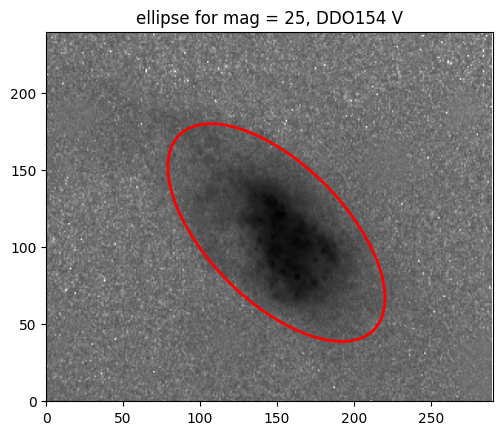

In [ ]:
from scipy.ndimage import gaussian_filter
import cv2
from scipy.optimize import curve_fit
from matplotlib.patches import Ellipse

initial_guess = [x, y, (max(x_points) - min(x_points)) / 2 , (max(y_points) - min(y_points)) / 2 , 0]
popt, pcov = curve_fit(ltf.ellipse, (x_points, y_points), np.zeros_like(x_points), p0=initial_guess)
stdv=np.sqrt(np.diag(pcov))
stdvx=stdv[0]
stdvy=stdv[1]
stdva=stdv[2]
stdvb=stdv[3]
stdvpa=stdv[4]

xc, yc, a, b, theta = popt

curve = ltf.ellipse(x_points,popt[0],popt[1],popt[2],popt[3],popt[4])

xc, yc, a, b, theta = popt
print(popt)
# Create a figure and axis
plt.figure()
ax = plt.gca()

# Display the other image
ax.imshow(v_box, cmap='gray' , origin = "lower")

# Create the ellipse
ellipse = Ellipse(xy=(xc, yc), width=2*a, height=2*b, angle=np.degrees(theta), edgecolor='r', facecolor='none', linewidth=2)

# Add the ellipse to the axis
ax.add_patch(ellipse)

# Set axis limits (adjust as needed)
ax.set_xlim(0,v_box.shape[1])
ax.set_ylim(0,v_box.shape[0])  # Reverse y-axis for imshow
plt.title("ellipse for mag = 25, DDO154 V")
# Show the plot
plt.show()